# Segmenting and Clustering Neighborhoods in Toronto
### Objectives
* Objectives 1: Extract Toronto Neighborhoods data from Webpage using BeautifulScoup
* Objectives 2: Cleaning and Convert to Pandas DataFrame
* Objectives 3: Add GeoLocation and Neighborhoods Data from FourSquare
* Objectives 4: Clustering with Sklearn K-means Algorithm


In [2]:
from bs4 import BeautifulSoup #Web Scrapping
import pandas as pd #library for dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
from tabulate import tabulate
import json #library for json file
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

In [3]:
# Import Toranto Neighbourhood wiki html file
import requests
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)
response.text[:100]

'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title'

In [4]:
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))[0]
df.head()


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [5]:
# Ignore cells with a borough that is Not assigned.
df = df[df['Borough'] != 'Not assigned']
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [9]:
tornto = df.groupby(['Postcode','Borough']).agg(lambda x: ','.join(set(x)))
tornto = tornto.reset_index()
tornto.columns = ['Postal Code','Borough','Neighborhood']
tornto.head(10)

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern,Rouge"
1,M1C,Scarborough,"Rouge Hill,Port Union,Highland Creek"
2,M1E,Scarborough,"West Hill,Guildwood,Morningside"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park"
7,M1L,Scarborough,"Oakridge,Golden Mile,Clairlea"
8,M1M,Scarborough,"Cliffside,Scarborough Village West,Cliffcrest"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


In [10]:
tornto.shape

(103, 3)

In [132]:
# Read GeoFile
geo_data = pd.read_csv('https://cocl.us/Geospatial_data')
geo_data.head()
#geo_data.to_csv(r'Data\geodata.csv')

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [133]:
tornto = pd.merge(tornto,geo_data,how='left',on='Postal Code')
tornto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Port Union,Highland Creek,Rouge Hill",43.784535,-79.160497
2,M1E,Scarborough,"West Hill,Morningside,Guildwood",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# Use geopy library to get the latitude and longitude values of Toronto City. 

In [134]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


In [135]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(tornto['Latitude'], tornto['Longitude'],tornto['Borough'], tornto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## The Cluster of Toronto 
<img src = "output\toronto_map.png" >

## Import _Foursquare_ Credential

In [153]:
CLIENT_ID = 'UBLX5C1RQM4EQJIT20SYTFY2YAMDC51IIGFTHGEHKXR2T44B' # Foursquare ID
CLIENT_SECRET = 'EQ5U14PRWPDADRFB5KEJY3CG4VBDABSWKWZQHTHSU5YPHTWO' #Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UBLX5C1RQM4EQJIT20SYTFY2YAMDC51IIGFTHGEHKXR2T44B
CLIENT_SECRET:EQ5U14PRWPDADRFB5KEJY3CG4VBDABSWKWZQHTHSU5YPHTWO


# Foursquare
### Function that extracts the category of the venue

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


#Extract Venues from FourSquare as lat and long given as input
def foursquareVenue(neighborhood_name, neighborhood_latitude, neighborhood_longitude,redius=500,limit=100):
    
    """Extract Venues from FourSquare as lat and long given as input"""
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
     CLIENT_ID, CLIENT_SECRET, VERSION, neighborhood_latitude, neighborhood_longitude, radius, LIMIT)
    
    print("Neighborhood Name: {}".format(neighborhood_name))

    #Get Url resopnse from FourSquare
    from pandas.io.json import json_normalize

    response = json_normalize(requests.get(url).json()["response"]['groups'][0]['items']) #Save as json file as normalized datafarme
    # clean columns
    columns_name = ['vanue','vanue_category','venue_latitude','venue_longitude']
    if response.empty:
        venues = pd.DataFrame(np.nan,index=[0],columns= columns_name)
    else:
    # filter columns
        venues = response.loc[:, ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']]

        # filter the category for each row
        # use function get_category_type() apply row wise in category object
        venues['venue.categories'] = venues.apply(get_category_type, axis=1)
        # clean columns
        venues.columns = columns_name
    #Add Neighborhood Details
    venues['neighborhood_name'], venues['neighborhood_latitude'], venues['neighborhood_longitude'] = neighborhood_name, neighborhood_latitude, neighborhood_longitude

    return venues


In [ ]:

neighborhood_latitude = tornto.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = tornto.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = tornto.loc[1, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of **{}** are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

In [ ]:
A = foursquareVenue('Upper Rouge',  43.836125, -79.205636)
B = foursquareVenue(neighborhood_name, neighborhood_latitude, neighborhood_longitude)
pd.concat([A,B],axis=0)


In [ ]:
column_names = foursquareVenue(neighborhood_name,  neighborhood_latitude, neighborhood_longitude).columns
df = pd.DataFrame(columns = column_names)

In [ ]:
df.head()

In [185]:
for neighborhood_name, neighborhood_latitude, neighborhood_longitude in zip(tornto['Neighborhood'],tornto['Latitude'],tornto['Longitude']):
    x = foursquareVenue(neighborhood_name,  neighborhood_latitude, neighborhood_longitude)
    df = pd.concat([df,x],axis=0)

Neighborhood Name: Rouge,Malvern
Neighborhood Name: Port Union,Highland Creek,Rouge Hill
Neighborhood Name: West Hill,Morningside,Guildwood
Neighborhood Name: Woburn
Neighborhood Name: Cedarbrae
Neighborhood Name: Scarborough Village
Neighborhood Name: Ionview,Kennedy Park,East Birchmount Park
Neighborhood Name: Oakridge,Golden Mile,Clairlea
Neighborhood Name: Cliffcrest,Cliffside,Scarborough Village West
Neighborhood Name: Birch Cliff,Cliffside West
Neighborhood Name: Scarborough Town Centre,Dorset Park,Wexford Heights
Neighborhood Name: Wexford,Maryvale
Neighborhood Name: Agincourt
Neighborhood Name: Clarks Corners,Sullivan,Tam O'Shanter
Neighborhood Name: Steeles East,Milliken,L'Amoreaux East,Agincourt North
Neighborhood Name: L'Amoreaux West
Neighborhood Name: Upper Rouge
Neighborhood Name: Hillcrest Village
Neighborhood Name: Oriole,Henry Farm,Fairview
Neighborhood Name: Bayview Village
Neighborhood Name: York Mills,Silver Hills
Neighborhood Name: Willowdale,Newtonbrook
Neighborho

In [189]:
#df = df.reset_index()
toronto_venues = df[['neighborhood_name','neighborhood_latitude', 'neighborhood_longitude','vanue', 'vanue_category', 'venue_latitude', 'venue_longitude']]
toroto_venues.head(10)

,neighborhood_name,neighborhood_latitude,neighborhood_longitude,vanue,vanue_category,venue_latitude,venue_longitude
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,Fast Food Restaurant,43.807448,-79.199056
1,"Rouge,Malvern",43.806686,-79.194353,Interprovincial Group,Print Shop,43.805630,-79.200378
2,"Port Union,Highland Creek,Rouge Hill",43.784535,-79.160497,Royal Canadian Legion,Bar,43.782533,-79.163085
3,"West Hill,Morningside,Guildwood",43.763573,-79.188711,G & G Electronics,Electronics Store,43.765309,-79.191537
4,"West Hill,Morningside,Guildwood",43.763573,-79.188711,Marina Spa,Spa,43.766000,-79.191000
5,"West Hill,Morningside,Guildwood",43.763573,-79.188711,Big Bite Burrito,Mexican Restaurant,43.766299,-79.190720
6,"West Hill,Morningside,Guildwood",43.763573,-79.188711,Enterprise Rent-A-Car,Rental Car Location,43.764076,-79.193406
7,"West Hill,Morningside,Guildwood",43.763573,-79.188711,Woburn Medical Centre,Medical Center,43.766631,-79.192286
8,"West Hill,Morningside,Guildwood",43.763573,-79.188711,Lawrence Ave E & Kingston Rd,Intersection,43.767704,-79.189490
9,"West Hill,Morningside,Guildwood",43.763573,-79.188711,Eggsmart,Breakfast Spot,43.767800,-79.190466


In [190]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['vanue_category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['neighborhood_name'] = toronto_venues['neighborhood_name'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,neighborhood_name,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hockey Arena,Home Service,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [191]:
toronto_grouped = toronto_onehot.groupby('neighborhood_name').mean().reset_index()
toronto_grouped

,neighborhood_name,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hockey Arena,Home Service,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.

In [192]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [193]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try: # try if in ['st', 'nd', 'rd'] else ['th']
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['neighborhood_name']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Skating Rink,Lounge,Breakfast Spot,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood,Long Branch",Pizza Place,Gym,Skating Rink,Pharmacy,Pool,Pub,Sandwich Place,Coffee Shop,Gas Station,Garden Center
2,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
3,Berczy Park,Coffee Shop,Seafood Restaurant,Cheese Shop,Beer Bar,Restaurant,Farmers Market,Café,Cocktail Bar,Bakery,Irish Pub
4,"Birch Cliff,Cliffside West",College Stadium,Skating Rink,Café,General Entertainment,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
5,"Bloordale Gardens,Eringate,Markland Wood,Old B...",Convenience Store,Liquor Store,Pizza Place,Coffee Shop,Shopping Plaza,Beer Store,Café,Cosmetics Shop,Doner Restaurant,Diner
6,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Skate Park,Brewery,Spa,Burrito Place,Farmers Market,Fast Food Restaurant,Restaurant,Butcher
7,"CFB Toronto,Downsview East",Snack Place,Park,Airport,Construction & Landscaping,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
8,Caledonia-Fairbanks,Park,Women's Store,Market,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
9,Canada Post Gateway Processing Centre,Coffee Shop,Hotel,Gym,American Restaurant,Mediterranean Restaurant,Sandwich Place,Burrito Place,Intersection,Middle Eastern Restaurant,Fried Chicken Joint


##  Clustering  **Toronto** Neighborhoods

In [194]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('neighborhood_name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=123).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 2, 2, 2, 2, 2, 2, 1, 2])

In [195]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tornto_merged = tornto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tornto_merged = tornto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

tornto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0,Print Shop,Fast Food Restaurant,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,M1C,Scarborough,"Port Union,Highland Creek,Rouge Hill",43.784535,-79.160497,3,Bar,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Event Space
2,M1E,Scarborough,"West Hill,Morningside,Guildwood",43.763573,-79.188711,2,Electronics Store,Medical Center,Rental Car Location,Spa,Mexican Restaurant,Breakfast Spot,Intersection,Diner,Discount Store,Distribution Center
3,M1G,Scarborough,Woburn,43.770992,-79.216917,2,Coffee Shop,Korean Restaurant,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,2,Gas Station,Bank,Fried Chicken Joint,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Bakery,Hakka Restaurant,Lounge,Drugstore


In [196]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tornto_merged['Latitude'],tornto_merged['Longitude'], tornto_merged['Neighborhood'], tornto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## The Cluster of Toronto 
<img src = "output\toronto_map_cluster.png" >

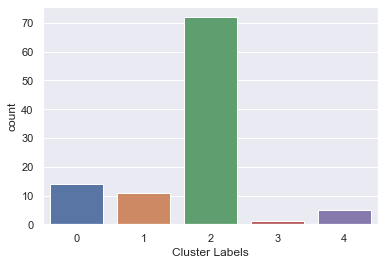

In [197]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x='Cluster Labels', data=tornto_merged)

## Conclusion
* Cluster 2 is the highest numbers in the segments.


In [219]:
for i in range(5):
    print('* Cluster {}:'.format(i))
    print("Number of Borough:{}".format(len(tornto_merged['Borough'].loc[tornto_merged['Cluster Labels'] == i].unique())))
    print(tornto_merged['Borough'].loc[tornto_merged['Cluster Labels'] == i].unique())
    print("Number of Neighborhood: {}\n".format(len(tornto_merged['Neighborhood'].loc[tornto_merged['Cluster Labels'] == i].unique())))


* Cluster 0:
Number of Borough:5
['Scarborough' 'North York' 'East York' 'York' 'Etobicoke']
Number of Neighborhood: 14

* Cluster 1:
Number of Borough:7
['Scarborough' 'North York' 'East York' 'Central Toronto'
 'Downtown Toronto' 'York' 'Etobicoke']
Number of Neighborhood: 11

* Cluster 2:
Number of Borough:9
['Scarborough' 'North York' 'East York' 'East Toronto' 'Central Toronto'
 'Downtown Toronto' 'West Toronto' 'Mississauga' 'Etobicoke']
Number of Neighborhood: 72

* Cluster 3:
Number of Borough:1
['Scarborough']
Number of Neighborhood: 1

* Cluster 4:
Number of Borough:3
['North York' 'Central Toronto' 'Etobicoke']
Number of Neighborhood: 5

